In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context(rc={"figure.figsize": (6,3)})
import scipy.stats as stats
import sklearn
import inspect
import numpy as np
import os

os.chdir(r'C:\Users\Igor\Jupyter_Notebook_Projects\Capstone project')

from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [2]:
# Importing CVD and RF data into a dataframe
df = pd.DataFrame.from_csv('Risk_Factors_CVD.csv', index_col=None)

In [3]:
## Cleaning data:
# Removing repetitive age categories as well as 18-24 group (null values for many factors)
# Removing 'Nutrition' topic (controversial)
# Removing 'Overall' break out and average US LocationID rows
# Selecting year - 2013 data set is most informative
# Removing Washington, DC (outlier, not a good representation)
# Removing 'Non-Hispanic Asian' group (not complete)
a = df.Break_out != '35+'
b = df.Break_out != '75+'
c = df.Break_out != '20-24'
d = df.Break_out != '18-24'
e = df.Break_out != 'Overall'
f = df.Break_out != 'Non-Hispanic Asian'
g = df.LocationAbbr != 'DC'
h = df.Year == 2013
i = df.LocationID != 0.5
j = df.Topic != 'Nutrition'

df1 = df[(a) & (b) & (c) & (d) & (e) & (f) & (g) & (h) & (i) & (j)] # creating a new df1

In [4]:
## Cleaning data:
# Removing repetitive indicators and creating new df2
list = ('post-hospitalization', 'Objective 6', 'Objective 7', 'screening', 'Objective 5', 'Objective 11', 'hypertension medication', 'Objective 8', 'Objective 9')

df2 = df1[~df.Indicator.str.contains('|'.join(list))]

C:\Users\Igor\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [5]:
## Cleaning data:
# Removing rows with null prevalence values and creating new df3
df3 = df2.dropna(subset=['Data_Value'])

In [6]:
# Renaming a few topics
df3 = df3.replace('Acute Myocardial Infarction (Heart Attack)', 'Heart_attack')
df3 = df3.replace('Coronary Heart Disease', 'CHD')
df3 = df3.replace('Physical Inactivity', 'Phys_inact')
df3 = df3.replace('Cholesterol Abnormalities', 'Cholesterol')

In [7]:
# Importing US states socioeconomic data (excluding Washingon, DC) from a csv file to a dataframe
df_us = pd.DataFrame.from_csv('USA_info_excl_DC.csv', index_col=None, encoding='cp1252')
df_us.head(5)

,LocationID,LocationDesc,GDP_2012,Healthcare_spending_2009,Bachelor_degree,Advanced_degree,Median_household_income_2014,Average_annual_Temp_C
0,1,Alabama,32615,6271.67,0.235,0.087,41415,17.1
1,2,Alaska,61156,9127.65,0.280,0.110,60287,-3.0
2,4,Arizona,35195,5433.89,0.275,0.102,46709,15.7
3,5,Arkansas,31837,6166.94,0.211,0.075,38758,15.8
4,6,California,46029,6237.61,0.314,0.116,67458,15.2


In [8]:
# Creating new dataframes for RF and CVD including location ID, which is to be used as a key for merging
# Grouping by state and calculating mean combined prevalence values for each state
rf = df3[(df3.Category == 'Risk Factors')][['LocationID', 'Topic', 'Data_Value']].groupby(['LocationID', 'Topic']).mean()
rf = rf.unstack('Topic')['Data_Value'].reset_index()
cvd = df3[df3.Category == 'Cardiovascular Diseases'][['LocationID', 'Topic', 'Data_Value']].groupby(['LocationID', 'Topic']).mean()
cvd = cvd.unstack('Topic')['Data_Value'].reset_index()

In [9]:
cvd.head()

Topic,LocationID,CHD,Heart_attack,Stroke
0,1.0,6.666667,7.216667,5.214286
1,2.0,5.066667,4.933333,3.700000
2,4.0,5.460000,5.300000,3.720000
3,5.0,7.357143,6.383333,5.771429
4,6.0,3.537500,4.033333,2.644444


In [10]:
# Preparing Geolocation dataframe
cvdGeo = df3[df3.Category == 'Cardiovascular Diseases'][['LocationID', 'GeoLocation', 'Data_Value']].groupby(['LocationID', 'GeoLocation']).mean().reset_index()
cvdLat = cvdGeo.drop('Data_Value', 1)
#cvdLat = pd.DataFrame(cvdGeo['GeoLocation'].map(lambda x: str(x)[1:10]).astype(float))
cvdLat['GeoLocation'] = cvdLat['GeoLocation'].str.extract('(\d\d.\d\d\d\d)', expand=True)
cvdLat = cvdLat.rename(columns={'GeoLocation': 'Latitude'})
cvdLat = cvdLat.apply(lambda x: pd.to_numeric(x, errors='ignore'))

cvdLon = cvdGeo.drop('Data_Value', 1)
#cvdLon = pd.DataFrame(cvdGeo['GeoLocation'].map(lambda x: str(x)[-20:-6]).astype(float))
cvdLon['GeoLocation'] = cvdLon['GeoLocation'].str.extract('(-[0-9]{1,3}.\d\d\d\d)', expand=True)
cvdLon = cvdLon.rename(columns={'GeoLocation': 'Longitude'})
cvdLon = cvdLon.apply(lambda x: pd.to_numeric(x, errors='ignore'))

cvdLatLon = pd.merge(cvdLat, cvdLon, on='LocationID', how='inner')

cvdLatLon.head()

,LocationID,Latitude,Longitude
0,1.0,32.8405,-86.6318
1,2.0,64.8450,-147.7220
2,4.0,34.8659,-111.7638
3,5.0,34.7486,-92.2744
4,6.0,37.6386,-120.9999


In [11]:
# Creating a dataframe combining geolocation data with US states socioeconomic data
df_us_del = df_us.drop('LocationDesc', axis=1)
df_us_geo = pd.merge(df_us_del, cvdLatLon, on='LocationID', how='inner')
df_us_geo.head()

,LocationID,GDP_2012,Healthcare_spending_2009,Bachelor_degree,Advanced_degree,Median_household_income_2014,Average_annual_Temp_C,Latitude,Longitude
0,1,32615,6271.67,0.235,0.087,41415,17.1,32.8405,-86.6318
1,2,61156,9127.65,0.280,0.110,60287,-3.0,64.8450,-147.7220
2,4,35195,5433.89,0.275,0.102,46709,15.7,34.8659,-111.7638
3,5,31837,6166.94,0.211,0.075,38758,15.8,34.7486,-92.2744
4,6,46029,6237.61,0.314,0.116,67458,15.2,37.6386,-120.9999


In [12]:
# Merging dataframes to include US states data with CVD and RF
df_merged_cvd_rf = pd.merge(cvd, rf, on='LocationID', how='inner')
df_merged = pd.merge(df_us_geo, df_merged_cvd_rf, on='LocationID', how='inner')
df_merged.head()

,LocationID,GDP_2012,Healthcare_spending_2009,Bachelor_degree,Advanced_degree,Median_household_income_2014,Average_annual_Temp_C,Latitude,Longitude,CHD,Heart_attack,Stroke,Cholesterol,Diabetes,Hypertension,Obesity,Phys_inact,Smoking
0,1,32615,6271.67,0.235,0.087,41415,17.1,32.8405,-86.6318,6.666667,7.216667,5.214286,41.925000,15.414286,40.611111,33.175000,31.777778,21.414286
1,2,61156,9127.65,0.280,0.110,60287,-3.0,64.8450,-147.7220,5.066667,4.933333,3.700000,37.044444,8.757143,36.666667,31.677778,24.650000,21.566667
2,4,35195,5433.89,0.275,0.102,46709,15.7,34.8659,-111.7638,5.460000,5.300000,3.720000,39.687500,12.622222,34.522222,28.975000,27.000000,15.871429
3,5,31837,6166.94,0.211,0.075,38758,15.8,34.7486,-92.2744,7.357143,6.383333,5.771429,40.966667,12.914286,39.655556,36.675000,35.977778,24.662500
4,6,46029,6237.61,0.314,0.116,67458,15.2,37.6386,-120.9999,3.537500,4.033333,2.644444,38.177778,12.544444,33.255556,24.977778,22.511111,12.211111


In [13]:
df_merged.shape

(50, 18)

## Clustering

## K-means

In [14]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from scipy.spatial.distance import cdist

In [15]:
# Creating a dataframe with features (predictors) to be analyzed - cluster variables
df_X = df_merged.drop(df_merged.ix[:,'CHD':'Stroke'].head(0).columns, 1)
df_X = df_X.drop('LocationID', 1)

In [16]:
clustervar = df_X.copy()

In [17]:
clustervar.loc[:] = scale(clustervar.loc[:].astype('float64'))

**Defining number of clusters**

In [18]:
clusters=range(1,10)
meandist=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(clustervar)
    clusassign=model.predict(clustervar)
    meandist.append(sum(np.min(cdist(clustervar, model.cluster_centers_, 'euclidean'), axis=1)) / clustervar.shape[0])

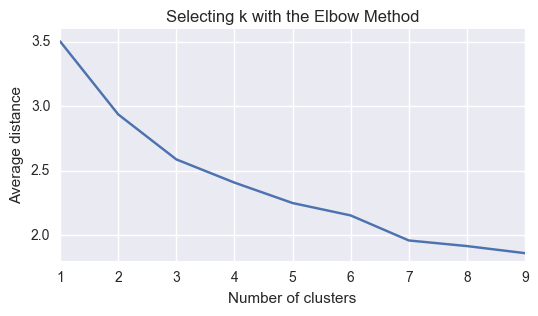

In [19]:
plt.plot(clusters, meandist)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method')

**Dividing data into 3 clusters using K-means method**

In [20]:
model3 = KMeans(n_clusters=3)
model3.fit(clustervar)
clusassign=model3.predict(clustervar)

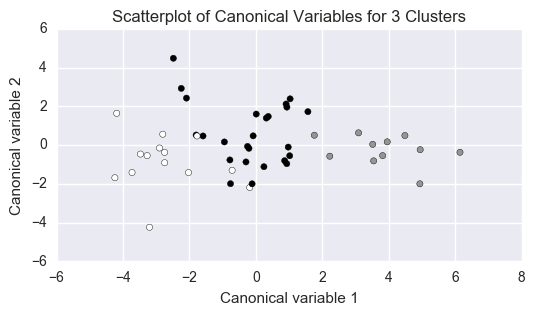

In [21]:
pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(clustervar)
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=model3.labels_,)
plt.xlabel('Canonical variable 1')
plt.ylabel('Canonical variable 2')
plt.title('Scatterplot of Canonical Variables for 3 Clusters')

In [22]:
clustervar.reset_index(level=0, inplace=True)

In [23]:
cluslist=clustervar['index'].tolist()
labels=model3.labels_.tolist()
newlist=dict(zip(cluslist, labels))
newclus = pd.DataFrame.from_dict(newlist, orient='index')
newclus.columns = ['cluster']

In [24]:
newclus.reset_index(level=0, inplace=True)

In [25]:
merged = pd.merge(clustervar, newclus, on='index')
merged.head()

,index,GDP_2012,Healthcare_spending_2009,Bachelor_degree,Advanced_degree,Median_household_income_2014,Average_annual_Temp_C,Latitude,Longitude,Cholesterol,Diabetes,Hypertension,Obesity,Phys_inact,Smoking,cluster
0,0,-1.199013,-0.752927,-1.128479,-0.798281,-1.101742,1.260186,-1.091670,0.374973,2.076632,2.467571,1.703113,0.770304,1.059615,0.763055,1
1,1,2.461891,2.324460,-0.207188,0.095607,1.073047,-2.943223,3.995189,-2.859885,-0.160117,-1.966426,0.459466,0.342896,-0.763285,0.806559,0
2,2,-0.868081,-1.655655,-0.309554,-0.215310,-0.491667,0.967412,-0.769749,-0.955821,1.051190,0.607914,-0.216657,-0.428659,-0.162282,-0.819399,2
3,3,-1.298806,-0.865776,-1.619834,-1.264657,-1.407932,0.988324,-0.788393,0.076185,1.637429,0.802444,1.401835,1.769440,2.133748,1.690401,1
4,4,0.521577,-0.789627,0.488898,0.328795,1.899426,0.862849,-0.329050,-1.444892,0.359287,0.556110,-0.616026,-1.569735,-1.310297,-1.864399,2


In [26]:
clustergrp = merged.groupby('cluster').mean()

In [27]:
print('                                       Clustering variable means by cluster')
clustergrp

                                       Clustering variable means by cluster


,index,GDP_2012,Healthcare_spending_2009,Bachelor_degree,Advanced_degree,Median_household_income_2014,Average_annual_Temp_C,Latitude,Longitude,Cholesterol,Diabetes,Hypertension,Obesity,Phys_inact,Smoking
cluster,,,,,,,,,,,,,,,
0,24.357143,0.940034,0.894642,1.208383,1.269876,1.146726,-0.577125,0.604784,0.386284,-0.183811,-0.848610,-0.499230,-0.792083,-0.401747,-0.551234
1,24.181818,-0.890878,-0.414416,-1.163842,-0.890143,-1.096263,0.836233,-0.700125,0.360159,1.150025,1.210856,1.533206,1.147050,1.294211,1.187218
2,24.720000,-0.134433,-0.318657,-0.164604,-0.319468,-0.159811,-0.044753,-0.030624,-0.374789,-0.403077,-0.057555,-0.395042,-0.061135,-0.344475,-0.213685


In [38]:
chd_data = df_merged[['CHD']]

In [39]:
chd_data.reset_index(level=0, inplace=True)

In [40]:
merged_all = pd.merge(chd_data, merged, on='index')

In [41]:
merged_all.head()

,index,CHD,GDP_2012,Healthcare_spending_2009,Bachelor_degree,Advanced_degree,Median_household_income_2014,Average_annual_Temp_C,Latitude,Longitude,Cholesterol,Diabetes,Hypertension,Obesity,Phys_inact,Smoking,cluster
0,0,6.666667,-1.199013,-0.752927,-1.128479,-0.798281,-1.101742,1.260186,-1.091670,0.374973,2.076632,2.467571,1.703113,0.770304,1.059615,0.763055,1
1,1,5.066667,2.461891,2.324460,-0.207188,0.095607,1.073047,-2.943223,3.995189,-2.859885,-0.160117,-1.966426,0.459466,0.342896,-0.763285,0.806559,0
2,2,5.460000,-0.868081,-1.655655,-0.309554,-0.215310,-0.491667,0.967412,-0.769749,-0.955821,1.051190,0.607914,-0.216657,-0.428659,-0.162282,-0.819399,2
3,3,7.357143,-1.298806,-0.865776,-1.619834,-1.264657,-1.407932,0.988324,-0.788393,0.076185,1.637429,0.802444,1.401835,1.769440,2.133748,1.690401,1
4,4,3.537500,0.521577,-0.789627,0.488898,0.328795,1.899426,0.862849,-0.329050,-1.444892,0.359287,0.556110,-0.616026,-1.569735,-1.310297,-1.864399,2


In [42]:
sub1 = merged_all[['CHD', 'cluster']].dropna()

In [43]:
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi

In [44]:
chdmod = smf.ols(formula='CHD ~ C(cluster)', data = sub1).fit()

In [45]:
print(chdmod.summary())

                            OLS Regression Results                            
Dep. Variable:                    CHD   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     8.762
Date:                Tue, 28 Feb 2017   Prob (F-statistic):           0.000583
Time:                        08:28:24   Log-Likelihood:                -65.214
No. Observations:                  50   AIC:                             136.4
Df Residuals:                      47   BIC:                             142.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           4.9733      0.246     

In [46]:
print('mean for CHD by cluster')
m1 = sub1.groupby('cluster').mean()
print(m1)

print('standard deviation for CHD by cluster')
m2 = sub1.groupby('cluster').std()
print(m2)

mc1 = multi.MultiComparison(sub1['CHD'], sub1['cluster'])
res1 = mc1.tukeyhsd()
print(res1.summary())

mean for CHD by cluster
              CHD
cluster          
0        4.973316
1        6.434632
2        5.250910
standard deviation for CHD by cluster
              CHD
cluster          
0        0.802721
1        1.050874
2        0.920464
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  0      1     1.4613   0.5645  2.3581  True 
  0      2     0.2776  -0.4654  1.0206 False 
  1      2    -1.1837   -1.989 -0.3784  True 
---------------------------------------------


## Affinity Propagation

**CHD**

In [51]:
from sklearn.cluster import AffinityPropagation
from sklearn.preprocessing import StandardScaler

In [52]:
# Defining independent and dependent variables for regression
X = df_X.values       #iloc[:,1:].values #reshape(-1, 1)
labels_true = df_merged['CHD'].values #reshape(-1, 1)
# normalize dataset for easier parameter selection
X = StandardScaler().fit_transform(X)

In [53]:
af = AffinityPropagation(preference=-50).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 4
Homogeneity: 0.328
Completeness: 0.978
V-measure: 0.492
Adjusted Rand Index: 0.010
Adjusted Mutual Information: 0.019
Silhouette Coefficient: 0.239


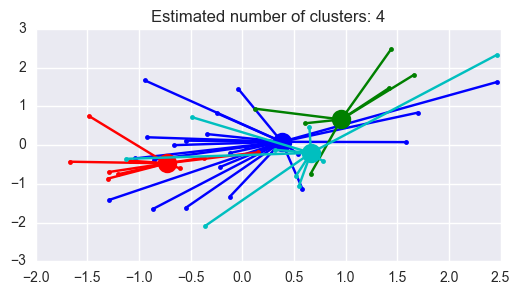

In [54]:
from itertools import cycle

plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)

**Heart Attack**

In [55]:
# Defining independent and dependent variables for regression
X = df_X.values       
labels_true = df_merged['Heart_attack'].values
# normalize dataset for easier parameter selection
X = StandardScaler().fit_transform(X)

In [56]:
af = AffinityPropagation(preference=-50).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 4
Homogeneity: 0.321
Completeness: 0.978
V-measure: 0.484
Adjusted Rand Index: -0.002
Adjusted Mutual Information: -0.003
Silhouette Coefficient: 0.239


**Stroke**

In [57]:
# Defining independent and dependent variables for regression
X = df_X.values       
labels_true = df_merged['Stroke'].values
# normalize dataset for easier parameter selection
X = StandardScaler().fit_transform(X)

In [58]:
af = AffinityPropagation(preference=-50).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 4
Homogeneity: 0.317
Completeness: 0.957
V-measure: 0.476
Adjusted Rand Index: -0.003
Adjusted Mutual Information: -0.006
Silhouette Coefficient: 0.239


## DBSCAN

In [59]:
# Defining independent and dependent variables for regression
X = df_X.values   #iloc[:,1:].values #reshape(-1, 1)
labels_true = df_merged['CHD'].values  #.reshape(-1, 1)
X = StandardScaler().fit_transform(X)

In [60]:
from sklearn.cluster import DBSCAN

In [61]:
db = DBSCAN(eps=0.3, min_samples=5).fit(X)
db.labels_

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=int64)

In [62]:
db = DBSCAN(eps=0.3, min_samples=5).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 0
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: -0.000


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)